In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime

In [2]:
DIRECTORY = os.getcwd()
PATH      = os.path.join(DIRECTORY, "scipy_data.csv")
PATH

'/home/nromerodiaz93/Documents/Universidad/JI/Carlos/Parameters/Yo/SciPy2019/Visualization/scipy_data.csv'

In [3]:
# Traemos los datos que hemos pre-procesado
#data = pd.read_csv(os.path.join(pathData,'depth_data.csv'))
data = pd.read_csv(PATH)

In [4]:
data.head()

,date_time,dia,nombre,tipo,precio,ASK,BID,Mid_price,Quoted_Spread,volumen,ASK_depth,BID_depth,Depth,log_depth
0,2017-03-03 09:30:00,2017-03-03,ECOPETL CB Equity,ASK,1320.0,1320.0,NaN,NaN,NaN,360000.0,360000.0,0.0,360000.0,12.793859
1,2017-03-03 09:30:00,2017-03-03,ECOPETL CB Equity,BID,1305.0,1320.0,1305.0,1312.5,0.011429,100000.0,360000.0,100000.0,460000.0,13.038982
2,2017-03-03 09:30:00,2017-03-03,PFAVAL CB Equity,BID,1105.0,NaN,NaN,NaN,NaN,350000.0,0.0,500000.0,500000.0,13.122363
3,2017-03-03 09:30:00,2017-03-03,PFAVAL CB Equity,BID,1105.0,NaN,NaN,NaN,NaN,150000.0,0.0,150000.0,150000.0,11.918391
4,2017-03-03 09:30:00,2017-03-03,ISA CB Equity,ASK,11480.0,11480.0,NaN,NaN,NaN,27000.0,27000.0,0.0,27000.0,10.203592


# Funciones
---
Comenzamos a definir las funciones necesarias para el análisis gráfico de los parámetros de calidad de mercado

In [5]:
# Funcion que calcula los dias habiles en Colombia

def business_days():
    # 2017
    weekmask = "Mon Tue Wed Thu Fri"
    holidays = [datetime.datetime(2017, 1, 9), datetime.datetime(2017, 3, 20), datetime.datetime(2017, 4, 13), 
                datetime.datetime(2017, 4, 14), datetime.datetime(2017, 5, 1), datetime.datetime(2017, 5, 29), 
                datetime.datetime(2017, 6, 19), datetime.datetime(2017, 6, 26), datetime.datetime(2017, 7, 3), 
                datetime.datetime(2017, 7, 20), datetime.datetime(2017, 8, 7), datetime.datetime(2017, 8, 21), 
                datetime.datetime(2017, 10, 16), datetime.datetime(2017, 11, 6), datetime.datetime(2017, 11, 13), 
                datetime.datetime(2017, 12, 8), datetime.datetime(2017, 12, 25)]

    BdaysCol2017 = pd.bdate_range(start = pd.datetime(2017, 1, 1), end = pd.datetime(2017, 12, 31), 
                                  freq = 'C',
                                  weekmask = weekmask, 
                                  holidays = holidays)
    
    return BdaysCol2017

In [25]:
# Funcion que formatea los datos de un parametro para una accion

# Esta funcion retorna una matriz indexada por la hora en las filas y por
# dias en las columnas con los datos del parametro "param_name" en el dia 
# y hora correspondientes

def get_stock_param(stockdata, stockticker, param_name):
    
    stockdata = stockdata[stockdata.nombre == stockticker + " CB Equity"]
    
    idx = pd.to_datetime(stockdata.date_time)
    stockdata.index = idx
    stockdata.replace(0, np.nan, inplace=True)
    
    bus_days = business_days()
    
    # Log-depth
    if(param_name == "log_depth"):        
        
        depth15min = stockdata.log_depth.resample("15T").mean()
        depth15min = depth15min.between_time('9:30','15:45')
        
        depth15min = pd.DataFrame(depth15min)
        depth15min.columns = ["avg_log_depth"]
        depth15min = depth15min.reset_index()
        
        depth15min['date'] = pd.to_datetime(depth15min.date_time.dt.date)
        depth15min['time'] = depth15min.date_time.dt.time
        
        # Nos quedamos con los datos de los dias habiles
        depth15minF = depth15min[depth15min.date.isin(bus_days)]
        
        # Quitamos columnas que ya no necesitamos
        depth15minF = depth15minF.drop(['date','time'],axis=1)
        
        # Pivoteamos los datos para que queden como indice la hora (vertical) y la fecha (horizontal)
        depth15minF = depth15minF.pivot_table(index=[depth15minF.date_time.dt.time, depth15minF.date_time.dt.date]).unstack(1)
        
        # Verificamos esta condicion que hizo Catalina
        depth15minF = depth15minF[depth15minF.sum(1)!=0]
        
        return depth15minF
    
    # Volatilidad
    elif(param_name == "Volatilidad"):
        x1 = stockdata[stockdata.tipo == "TRADE"]
        
        vol15max =  x1.precio.resample("15T").max()
        vol15min =  x1.precio.resample("15T").min()
        logmax   = np.log(vol15max)
        logmin   = np.log(vol15min)
        #Parkinson (1980)
        # daily vol
        vola15min = np.sqrt(25)*np.sqrt(((logmax - logmin)**2)/(4*np.log(2))) 
        #there are 25, 15 min intervals in trading day
        vola15min = vola15min.between_time('9:30','15:45')
        vola15min = vola15min.reset_index()
        
        vola15min['date'] = pd.to_datetime(vola15min.date_time.dt.date)
        vola15min['time'] = vola15min.date_time.dt.time
        
        # Nos quedamos con los datos de los dias habiles
        vola15minF=vola15min[vola15min.date.isin(bus_days)]
        
        # Quitamos las columnas que ya no necesitamos
        vola15minF = vola15minF.drop(['date','time'],axis=1)
        
        # Pivoteamos los datos para que queden como indice la hora (vertical) y la fecha (horizontal)
        vola15minF = vola15minF.pivot_table(index=[vola15minF.date_time.dt.time, vola15minF.date_time.dt.date]).unstack(1)
        
        # Verificamos esta condicion que hizo Catalina
        vola15minF = vola15minF[vola15minF.sum(1)!=0]
        
        return vola15minF
    
    # Spread
    elif(param_name == "Spread"):
        spread15min = stockdata.Quoted_Spread.resample("15T").mean()
        spread15min = spread15min.between_time('9:30','15:45')
        spread15min = spread15min.reset_index()
        
        spread15min['date'] = pd.to_datetime(spread15min.date_time.dt.date)
        spread15min['time'] = spread15min.date_time.dt.time
        
        # Nos quedamos con los datos de los dias habiles
        spread15minF = spread15min[spread15min.date.isin(bus_days)] 
        
        # Quitamos las columnas que ya no necesitamos
        spread15minF=spread15minF.drop(['date','time'],axis=1)
        
        # Pivoteamos los datos para que queden como indice la hora (vertical) y la fecha (horizontal)
        spread15minF = spread15minF.pivot_table(index=[spread15minF.date_time.dt.time, spread15minF.date_time.dt.date]).unstack(1)
        
        # Verificamos esta condicion que hizo Catalina
        spread15minF = spread15minF[spread15minF.sum(1)!=0]
        
        return 10000*spread15minF
    
    # Volumen
    elif(param_name == "Volumen"):
        x1 = stockdata[stockdata.tipo == "TRADE"]
        
        vol15min = x1.volumen.resample("15T").sum().fillna(value=0)
        vol15min = vol15min.reset_index()
        
        vol15min['date'] = pd.to_datetime(vol15min.date_time.dt.date)
        vol15min['time'] = vol15min.date_time.dt.time
        
        #select only business days colombia
        vol15minF=vol15min[vol15min.date.isin(bus_days)]
        
        # Quitamos las columnas que ya no necesitamos
        vol15minF=vol15minF.drop(['date','time'],axis=1)
        
        # Pivoteamos los datos para que queden como indice la hora (vertical) y la fecha (horizontal)
        vol15minF = vol15minF.pivot_table(index=[vol15minF.date_time.dt.time, vol15minF.date_time.dt.date]).unstack(1)
        
        # Tomamos el log-volumen
        vol15minP = np.log(vol15minF["volumen"] + 1)
        
        # Verificamos esta condicion que hizo Catalina
        vol15minP = vol15minP[vol15minP.sum(1) != 0]
        
        # Remover ceros
        vol15minP.replace(0.0, np.nan, inplace=True)
        
        return vol15minP
    
    # Retornos
    elif(param_name == "Retorno"):
        ret15min = stockdata.retorno.resample("15T", how='mean', ffil_method='bfill')#.mean()
        ret15min = ret15min.between_time('9:30','15:45')
        ret15min = ret15min.reset_index()
        
        ret15min['date'] = pd.to_datetime(ret15min.date_time.dt.date)
        ret15min['time'] = ret15min.date_time.dt.time
        
        # Nos quedamos con los datos de los dias habiles
        ret15minF = ret15min[ret15min.date.isin(bus_days)]
        
        # Quitamos las columnas que ya no necesitamos
        ret15minF = ret15minF.drop(['date', 'time'], axis=1)
        
        # Pivoteamos los datos para que queden como indice la hora (vertical) y la fecha (horizontal)
        ret15minF = ret15minF.pivot_table(index=[ret15minF.date_time.dt.time, ret15minF.date_time.dt.date]).unstack(1)
        
        # Verificamos esta condicion que hizo Catalina
        ret15minF = ret15minF[ret15minF.sum(1)!=0]
        
        return ret15minF

In [27]:
# Funcion que grafica los resultados

def graph(stockdata, stockticker, param_name):
    
    df = get_stock_param(stockdata, stockticker, param_name)
    xx = []
    yy = []
    
    # Ponemos el spread en bp
    if(param_name == "Spread"):
        param_name = "Spread (bp)"
    
    cont = 0 #El contador sera nuestro eje x, pondremos las horas correspondientes sobre esto
    xxq  = []
    yy25 = []
    yy50 = []
    yy75 = []
    
    # Primer ciclo para recorrer las horas (filas) 
    for row in df.iterrows():
        cont += 1
        xxq.append(cont)
        
        yy25.append( np.nanpercentile(row[1].values, 25) )
        yy50.append( np.nanpercentile(row[1].values, 50) )
        yy75.append( np.nanpercentile(row[1].values, 75) )
        
        # Segundo ciclo para recorrer los dias (columnas)
        for i in range(len(row[1])):
            xx.append(cont)
            yy.append(row[1][i])
            
            
    xx = np.array(xx)
    yy = np.array(yy)
    xy = np.vstack([xx, yy])
    # La funcion stats.gaussian_kde() no acepta NaN, entonces aqui los reemplazo por cero 
    # despues de ya haber calculado los cuantiles
    xy[np.isnan(xy)] = 0.0
    #xy = xy[xy>0.0]
    z  = stats.gaussian_kde(xy)(xy) # Este comando colorea los puntos

    idx = z.argsort() # Ordenamos los puntos para que queden los mas rojos encima de los azules
    xx, yy, z = xx[idx], yy[idx], z[idx]
    
    # Ticks eje x
    timelab = ('9:15','9:30','9:45','10:00','10:15','10:30','10:45','11:00', '11:15','11:30','11:45','12:00',
               '12:15','12:30','12:45','13:00','13:15', '13:30','13:45','14:00','14:15','14:30','14:45',
               '15:00','15:15','15:30','15:45','16:00')
    
    # Convertimos a array
    xxq  = np.array(xxq)
    yy25 = np.array(yy25)
    yy50 = np.array(yy50)
    yy75 = np.array(yy75)
    
    # Limites de la figura
    y_min = np.nanmin(yy)
    y_max = np.nanmax(yy)
    delta = 0.05*(y_max-y_min) # Ajuste para los ylim de la grafica
        
    # Grafica
    plt.figure(figsize=(17, 10))
    
    plt.scatter(xx, yy, c=z, s=100, edgecolor='') # Todos los datos
    plt.plot(xxq, yy25, linewidth = 1, c = "g")   # Cuantil 25
    plt.plot(xxq, yy50, linewidth = 2, c = "r")   # Cuantil 50
    plt.plot(xxq, yy75, linewidth = 1, c = "g")   # Cuantil 75
    
    # Titulo y ejes
    plt.title(param_name + " " + stockticker, fontsize=30)
    plt.xlabel("Hora",     fontsize = 20)
    plt.ylabel(param_name, fontsize=20)
    plt.xticks(np.arange(27), timelab, rotation=17)
    plt.colorbar()
    
    plt.ylim((y_min-delta, y_max+delta))
    #plt.savefig(stockticker+param_name+".pdf", bbox_inches="tight")
    plt.show()

# Aplicación
---
Evaluamos la función que formatea la matriz de datos

In [8]:
param_list = ["log_depth", "Volatilidad", "Spread", "Volumen"]

In [20]:
# Testeamos la funcion get_stock_param()

dep   = get_stock_param(data, "ECOPETL", param_list[0])
volat = get_stock_param(data, "ECOPETL", param_list[1])
spr   = get_stock_param(data, "ECOPETL", param_list[2])
volum = get_stock_param(data, "ECOPETL", param_list[3])

/home/nromerodiaz93/.local/lib/python3.6/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [21]:
#volum[volum[volum.columns] != 0.0].tail()
volat.head()

precio                                                         \
date_time 2017-03-03 2017-03-06 2017-03-07 2017-03-08 2017-03-09 2017-03-10   
date_time                                                                     
09:30:00    0.022922   0.033930   0.045498   0.011396   0.011661   0.045845   
09:45:00    0.011396   0.011353   0.011353   0.011396   0.000000   0.011439   
10:00:00    0.011353   0.011396   0.022663   0.011396   0.011707   0.000000   
10:15:00    0.011353   0.011396   0.011353   0.011396   0.000000   0.011483   
10:30:00    0.011310   0.011396   0.000000   0.011310   0.011707   0.011527   

                                                       ...             \
date_time 2017-03-13 2017-03-14 2017-03-15 2017-03-16  ... 2017-08-17   
date_time                                              ...              
09:30:00    0.022835   0.034715   0.011572   0.022835  ...   0.033181   
09:45:00    0.000000   0.023278   0.011572   0.011439  ...   0.000000   
10:00:00    0.011353   0.023368   0.000000   0.011439  ...   0.011019   
10:15:00    0.011353   0.011661   0.000000   0.022922  ...   0.000000   
10:30:00    0.011353   0.011661   0.011572   0.011483  ...   0.010979   

                                                                             \
date_time 2017-08-18 2017-08-22 2017-08-23 2017-08-24 2017-08-25 2017-08-28   
date_time                                                                     
09:30:00    0.022080   0.011019   0.010979   0.010979   0.011019   0.022161   
09:45:00    0.011019   0.021999   0.011019   0.010939   0.011019   0.011142   
10:00:00    0.000000   0.010979   0.000000   0.010939   0.000000   0.011184   
10:15:00    0.011019   0.010979   0.011019   0.010939   0.010979   0.022326   
10:30:00    0.011019   0.010979   0.021918   0.000000   0.000000   0.011142   

                                            
date_time 2017-08-29 2017-08-30 2017-08-31  
date_time                                   
09:30:00    0.011184   0.022326   0.011101  
09:45:00    0.022409   0.000000   0.000000  
10:00:00    0.011184   0.011142   0.011101  
10:15:00    0.000000   0.011142   0.000000  
10:30:00    0.011184   0.011142   0.011101  

[5 rows x 119 columns]

# Gráficas
---
Ensayamos la función que grafica los parámetros de calidad de mercado

/home/nromerodiaz93/.local/lib/python3.6/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


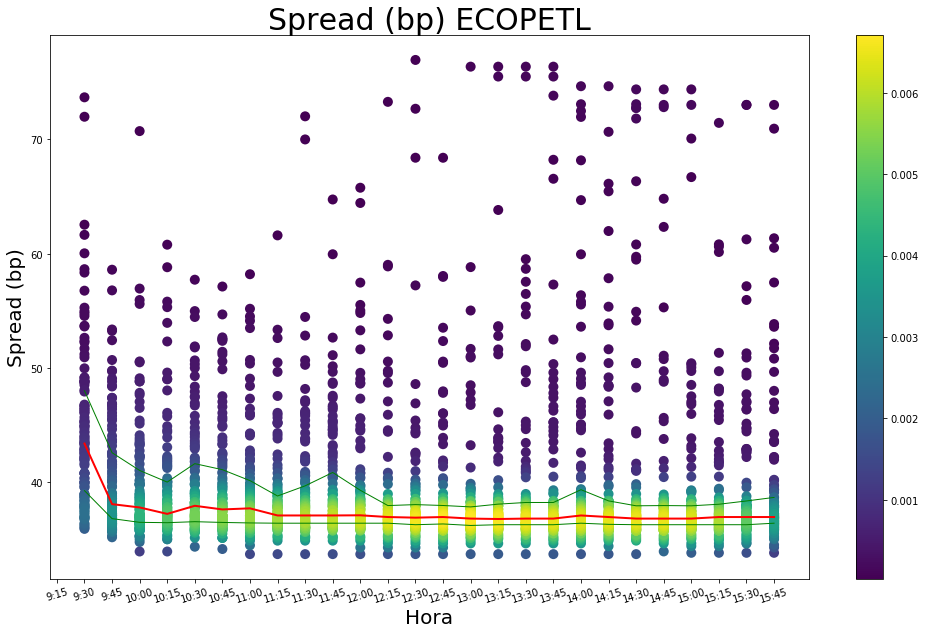

In [29]:
# Testeamos la funcion graph()

param_list = ["log_depth", "Volatilidad", "Spread", "Volumen"]
K = 2

graph(data, "ECOPETL", param_list[K])